## Problème de prédiction du type de cancer de la peau : distinction entre tumeurs bénignes et malignes à l’aide des couches conv2D

Dans le Lab 1 et 2, nous avons appris à utiliser les algorithmes de l'apprentissage automatique, un Multi-Layer Perceptron, et une couche de convolution 1D pour construire un modèle de classification capable de distinguer les tumeurs bénignes des tumeurs malignes.

Aujourd'hui, nous allons explorer l'utilisation des couches de convolution en 2D.

Pour cela, nous allons utiliser la bibliothèque Keras, en particulier la couche Conv2D, afin de résoudre ce problème de classification.

À la fin de ce TP, vous serez capable de :

 - définir un problème d'apprentissage machine.

 - comprendre le mécanisme de fonctionnement d'une couche de convolution 2D.

 - connaître l'implémentation d'une couche de convolution 2D à l'aide de la bibliothèque Keras.

 - comprendre les techniques d'augmentation des données par transformation des images, notamment (normalization, scaling, tilting, resizing).

 - savoir implémenter un script pour identifier les régions les plus pertinentes pour un modèle d'apprentissage notamment, mettre en évidence la région d'une image
 sur laquelle les yeux des gens se concentrent en premier (saliency maps).

C'est parti !

## Table de matière

 - Importation des bibliothèques essentielles

 - Partie 0:

    - Définir le type de problème d'apprentissage machine

 - Partie 1:

    - Extraction des données

    - Chargement des données 

    - Transformation des données

 - Partie 2:
   
    - Visualisation des données 


 - Partie 3:

    - Encodage de la variable cible


 - Partie 4:

    - Section des données en sous-échantillons de données (données d'entraînement de validation et de test)


 - Partie 5:

    - Implémentation de l'algorithme

 - Partie 6:

    - Entraînement du modèle

 - Partie 7:

    - Tester et valider le modèle


 - Partie 8:

    - Inférence

 - Partie 9:

    - Modèle préentraîné:



## Importer les bibliothèques essentielles

In [1]:
! pip install pandas
! pip install scikit-learn
! pip install opencv-python
! pip install tensorflow
! pip install --upgrade keras
! pip install pydot
! pip install numpy
! pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [36]:
from pathlib import Path
from  glob import glob
import os
import cv2
import copy
import time
import random

In [3]:
import numpy as  np
import pandas as pd
import matplotlib.pyplot as plt

In [330]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.optimizers import Adam, SGD, schedules
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras import callbacks, applications

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

## Partie 0

- Définir le type de problème d'apprentissage machine

...

## Partie 1

- Extraction des données

- Chargement des données 

- Transformation des données

#### Définition d'une classe pour charger et transformer les données

In [63]:

class CustomDataset:
    def __init__(self, proportion: float, root: Path, train: bool, size : tuple,shuffle:bool, normalize: bool):
        """
        Initialisation de l'objet CustomDataset avec la proportion des données à utiliser
        et le répertoire racine contenant les images.

        :param proportion: Proportion des données à charger (0 à 1).
        :param root: Répertoire racine où se trouvent les images.
        """
        self.proportion = proportion

        self.root = root

        self.data = {"images": [], "Target": []}

        self.target = ["benign", "malignant"]
       
        self.dataType = "train" if train else "test" 

        self.size =  size

        self.normalize = normalize

        self.shuffle = shuffle
    

    def dataloader(self):
        """
        Charge et traite les images depuis les répertoires 'benign' et 'malignant', 
        en appliquant une proportion des données spécifiée.

        :return: Tuple contenant les caractéristiques (Images) et les cibles (Target) des données.
        """
        
        # Initialisation des listes pour les images et les cibles
        images = []

        targets = []
        
        # Chargement des images et valeurs cibles benign et malignant
        for item in self.target:
            files = glob(os.path.join(self.root, f"{self.dataType}/{item}/*.jpg"))
            num_files = int(len(files) * self.proportion)

            # Ajout des images et des cibles dans les listes correspondantes
            images.extend([cv2.resize(cv2.imread(imagePath) / 255.0, self.size).astype(np.float32) 
                        if self.normalize else cv2.resize(cv2.imread(imagePath), self.size).astype(np.float32) 
                        for imagePath in files[:num_files]])

            targets.extend([item for _ in range(num_files)])

        # Combinaison des images et cibles en une seule liste de tuples
        combined = list(zip(images, targets))

        # Mélange des données si shuffle est True
        if self.shuffle:
            random.shuffle(combined)

        # Séparation des images et cibles après le shuffle
        self.data["images"], self.data["Target"] = zip(*combined)

        return list(self.data["images"]), list(self.data["Target"])


### Charger les données disponibles dans un dossier dont vous connaissez le chemin

#### Définir le chemin vers le dossier contenant les données

In [251]:

root = "/home/laris/laris/cours/CV50/inputs/raw/data/"

##### Définir la proportion des données à charger

In [252]:
proportion = 0.3

##### Charger et transformer les données

In [253]:
datasets = CustomDataset(proportion=proportion, root = root, train=True, size=(224,224),shuffle=True, normalize=True)

In [254]:
images , target = datasets.dataloader()

 - Partie 2:
   
    - Visualisation des données 

#### Afficher aléatoirement 9 images de type de cancer de la peau

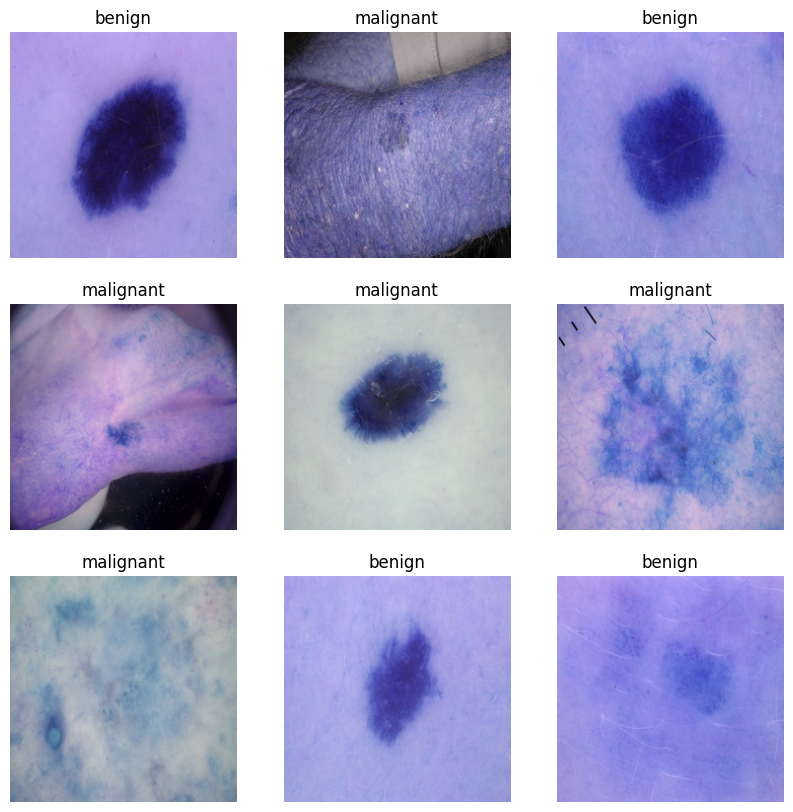

In [255]:
plt.figure(figsize=(10, 10))
i = 0
for  image, label in zip(images[:9],target[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(image*255).astype("uint8"))
    plt.title(label)
    plt.axis("off")
    i+=1

#### Afficher une image de type de cancer de la peau sur 4 canaux d'encodage d'image (red, green, blue, gris)

In [256]:
#Définir l'image
images_ = images[:9]

idx = random.randint(a=1, b=8)

image = images_[idx]

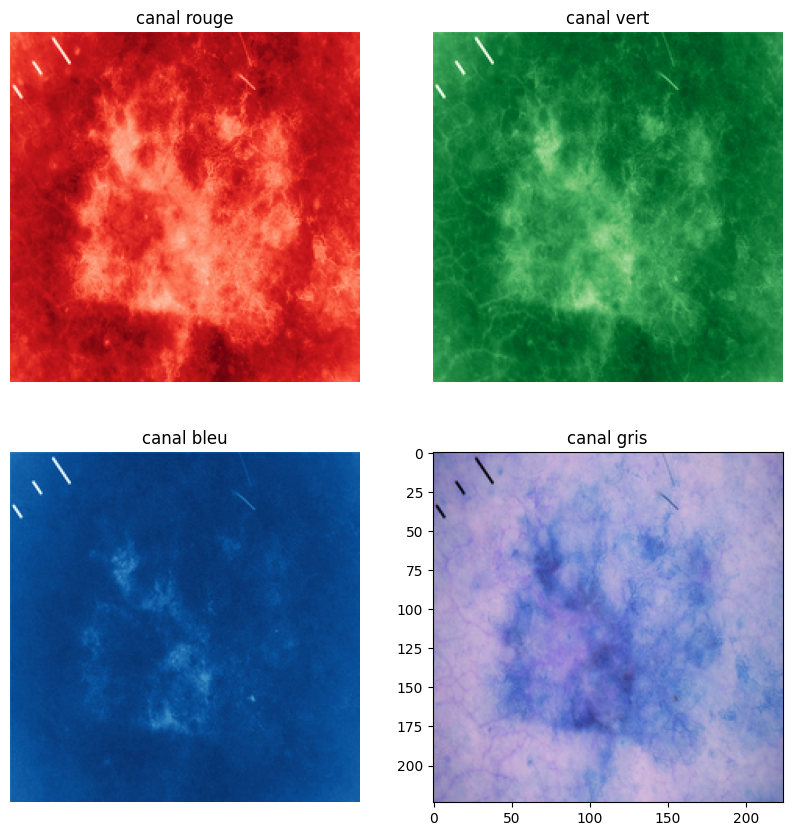

In [257]:
colors = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues, plt.cm.Greys]
labels = ["canal rouge", "canal vert", "canal bleu", "canal gris"]

plt.figure(figsize=(10, 10))

i = 0

for color, label in zip(colors, labels):
    ax = plt.subplot(2, 2, i + 1)

    if i<3:
        plt.imshow(image[:,:,i], cmap=color)
        plt.title(label)
        plt.axis("off")
    else:
        plt.title(labels[i])
        plt.imshow(image) 
        plt.show()
    i+=1

## Partie 3:

- Encodage de la variable cible


#### Encoder la variable cible sous forme d'entier pour pouvoir faire l'entraînement

Exemple:

- benign -----> 0

- malignant ----> 1

#### Encoder les valeurs cibles à l'aide de map

In [258]:

target = [0 if item=='benign' else 1 for item in target]

#### Convertir en matrice de données

In [259]:
X_Train = np.array(images)
Y_Train = np.array(target)

## Partie 4:

 - Section des données en sous-échantillons de données (données d'entraînement de validation et de test)


In [260]:
# À l'aide de sklearn, écrivez une fonction pour diviser les données en ensemble d'apprentissage et de validation
x_train, x_val, y_train, y_val = train_test_split(X_Train, Y_Train, test_size=0.25, shuffle=True, random_state=42)

## Partie 5:

 - Implémentation de l'algorithme

#### Conv2D

Comme mentionner au cours, Un noyau de convolution est un masque utilisé pour transformer les images, notamment flouté, amélioré la qualité, déformé l’image, détecté les contours, et d'autres. Il permet d'extraire les informations pertinenetes de l'image.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS0EyCbjUVZp-BxyHS9c1aW9-ydxiG4fHXOSg&s" alt="description de l'image" width="700" height="250">






#### a) Conv2D de keras 

keras.layers.Conv2D (filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, kernel_initializer='glorot_uniform', data_format='channels_last', bias_initializer='zeros')

#### b) Pooling layers

Cette couche permet de rédiure la taille de la matrice de données et supprimer les informations inutiles. Cette couche utilise des opérations comme  le maximum :max() et la moyenne : avg()

<img src="https://www.researchgate.net/publication/333593451/figure/fig2/AS:765890261966848@1559613876098/llustration-of-Max-Pooling-and-Average-Pooling-Figure-2-above-shows-an-example-of-max.png" alt="description de l'image" width="700" height="350">


#### MaxPooling2D de keras

keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

#### c) Dropout Layers
La couche Dropout permet au réseau de désactiver aléatoirement une portion de neurones pendant l'entraînement

Cette technique aide à prévenir le surapprentissage (overfitting)


<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif" alt="description de l'image" width="500" height="300">


#### Dropout avec keras 

keras.layers.Dropout(rate, seed=None)

#### d) Couches densement connectées

Une couche entièrement connectée est la partie linéaire du réseau. Elle permet de projeter un vecteur dans une dimension plus petite.

À la sortie de celle-ci, nous pouvons utiliser une fonction d'activation sigmoïde ou softmax pour obtenir les probabilités des différentes classes.

<img src="https://developers.google.com/static/machine-learning/guides/text-classification/images/LinearStackOfLayers.png?hl=fr" alt="description de l'image" width="500" height="300">

#### Couches densement connectées avec keras

keras.layers.Dense(units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')

#### La fonction d'activation de la couche de sortie
Comme notre problème est un problème de classification binaire, nous voulons que la sortie du neuronne produise une probabilité dans l'intervalle [0, 1]. Pour cela nous allons utilser la **fonction sigmoïde** utiliser dans les modèles de régression logistique.


$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

<img src="https://developers.google.com/static/machine-learning/guides/text-classification/images/LastLayer.png?hl=fr" alt="description de l'image" width="700" height="300">


## Création d'une architecture de type MLP en utilisant les couches conv2D

Nous utiliserons un modèle séquentiel avec des couches de covolution, des couches densément connectées et une couche de sortie dont la fonction d'activation est la fonction sigmoïde

#### Définir les configurations pour l'entraînement

In [261]:
verbose = 1

In [338]:
#Définir la fonction d'activation de la dernière couche
activationF= 'sigmoid'

# Définir la fonction coût
loss = 'binary_crossentropy'

# Définir la métrique d'évaluation
metrics = ['accuracy']

# Définir le nombre d'époques et le nombre d'exemples à mettre dans l'algorithme

epochs = 20

# Définir le nombre d'exemples
batch_size = 8

# Définir l'algorithme d'optimisation
# optimizer = 'sgd'
#optimizer = Adam(learning_rate==0.001)
#optimizer = RMSprop(lr=1e-2)

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = SGD(learning_rate=lr_schedule)

In [263]:
#Déterminer la taille des images pour pourvoir définir les entrés de la première couche de convolution
x_train.shape

(593, 224, 224, 3)

#### Faire l'architecture du modèle

In [264]:
# Créer un modèle séquentiel
model = Sequential(name="model_alpha") 

In [265]:
# Ajouter la couche de convolution avec la forme des images (width, height, chanel)
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides= (1,1) , padding='valid', activation='elu', input_shape=((224,224, 3))))
          
# AJouter une couche de Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

# Ajouter la couche de convolution

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='elu')) 

# AJouter une couche de Max pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

/home/laris/.local/share/virtualenvs/CV50-wqJSEKW2/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [266]:
# # Applatir les matrices de données issues des convolutions pour les préparer à la couche dense suivante
model.add(Flatten())

In [267]:
# Ajouter une couche dense avec 256 neurones et une activation ELU
model.add(Dense(256, activation='elu', name="Dense_1"))

# Ajouter une couche dense
model.add(Dense(32, activation='elu'))

# Ajouter une couche de dropout pour éviter le surapprentissage, avec un taux de 50%
model.add(Dropout(0.2))

# Ajouter une couche dense avec 32 neurones et une activation ELU
model.add(Dense(32, activation='elu', name="Dense_2"))

# Ajouter une couche dense finale avec un neurone pour la sortie (activation définie par 'activationF')
model.add(Dense(1, activation=activationF, name="Dense_3"))


#### Sommaire des différentes couches de votre modèle

In [268]:
model.summary()

Model: "model_alpha"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 256)            │    47,776,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,804,705 (182.36 MB)

 Trainable params: 47,804,705 (182.36 MB)

 Non-trainable params: 0 (0.00 B)

#### Afficher le schéma associé  à votre modèle

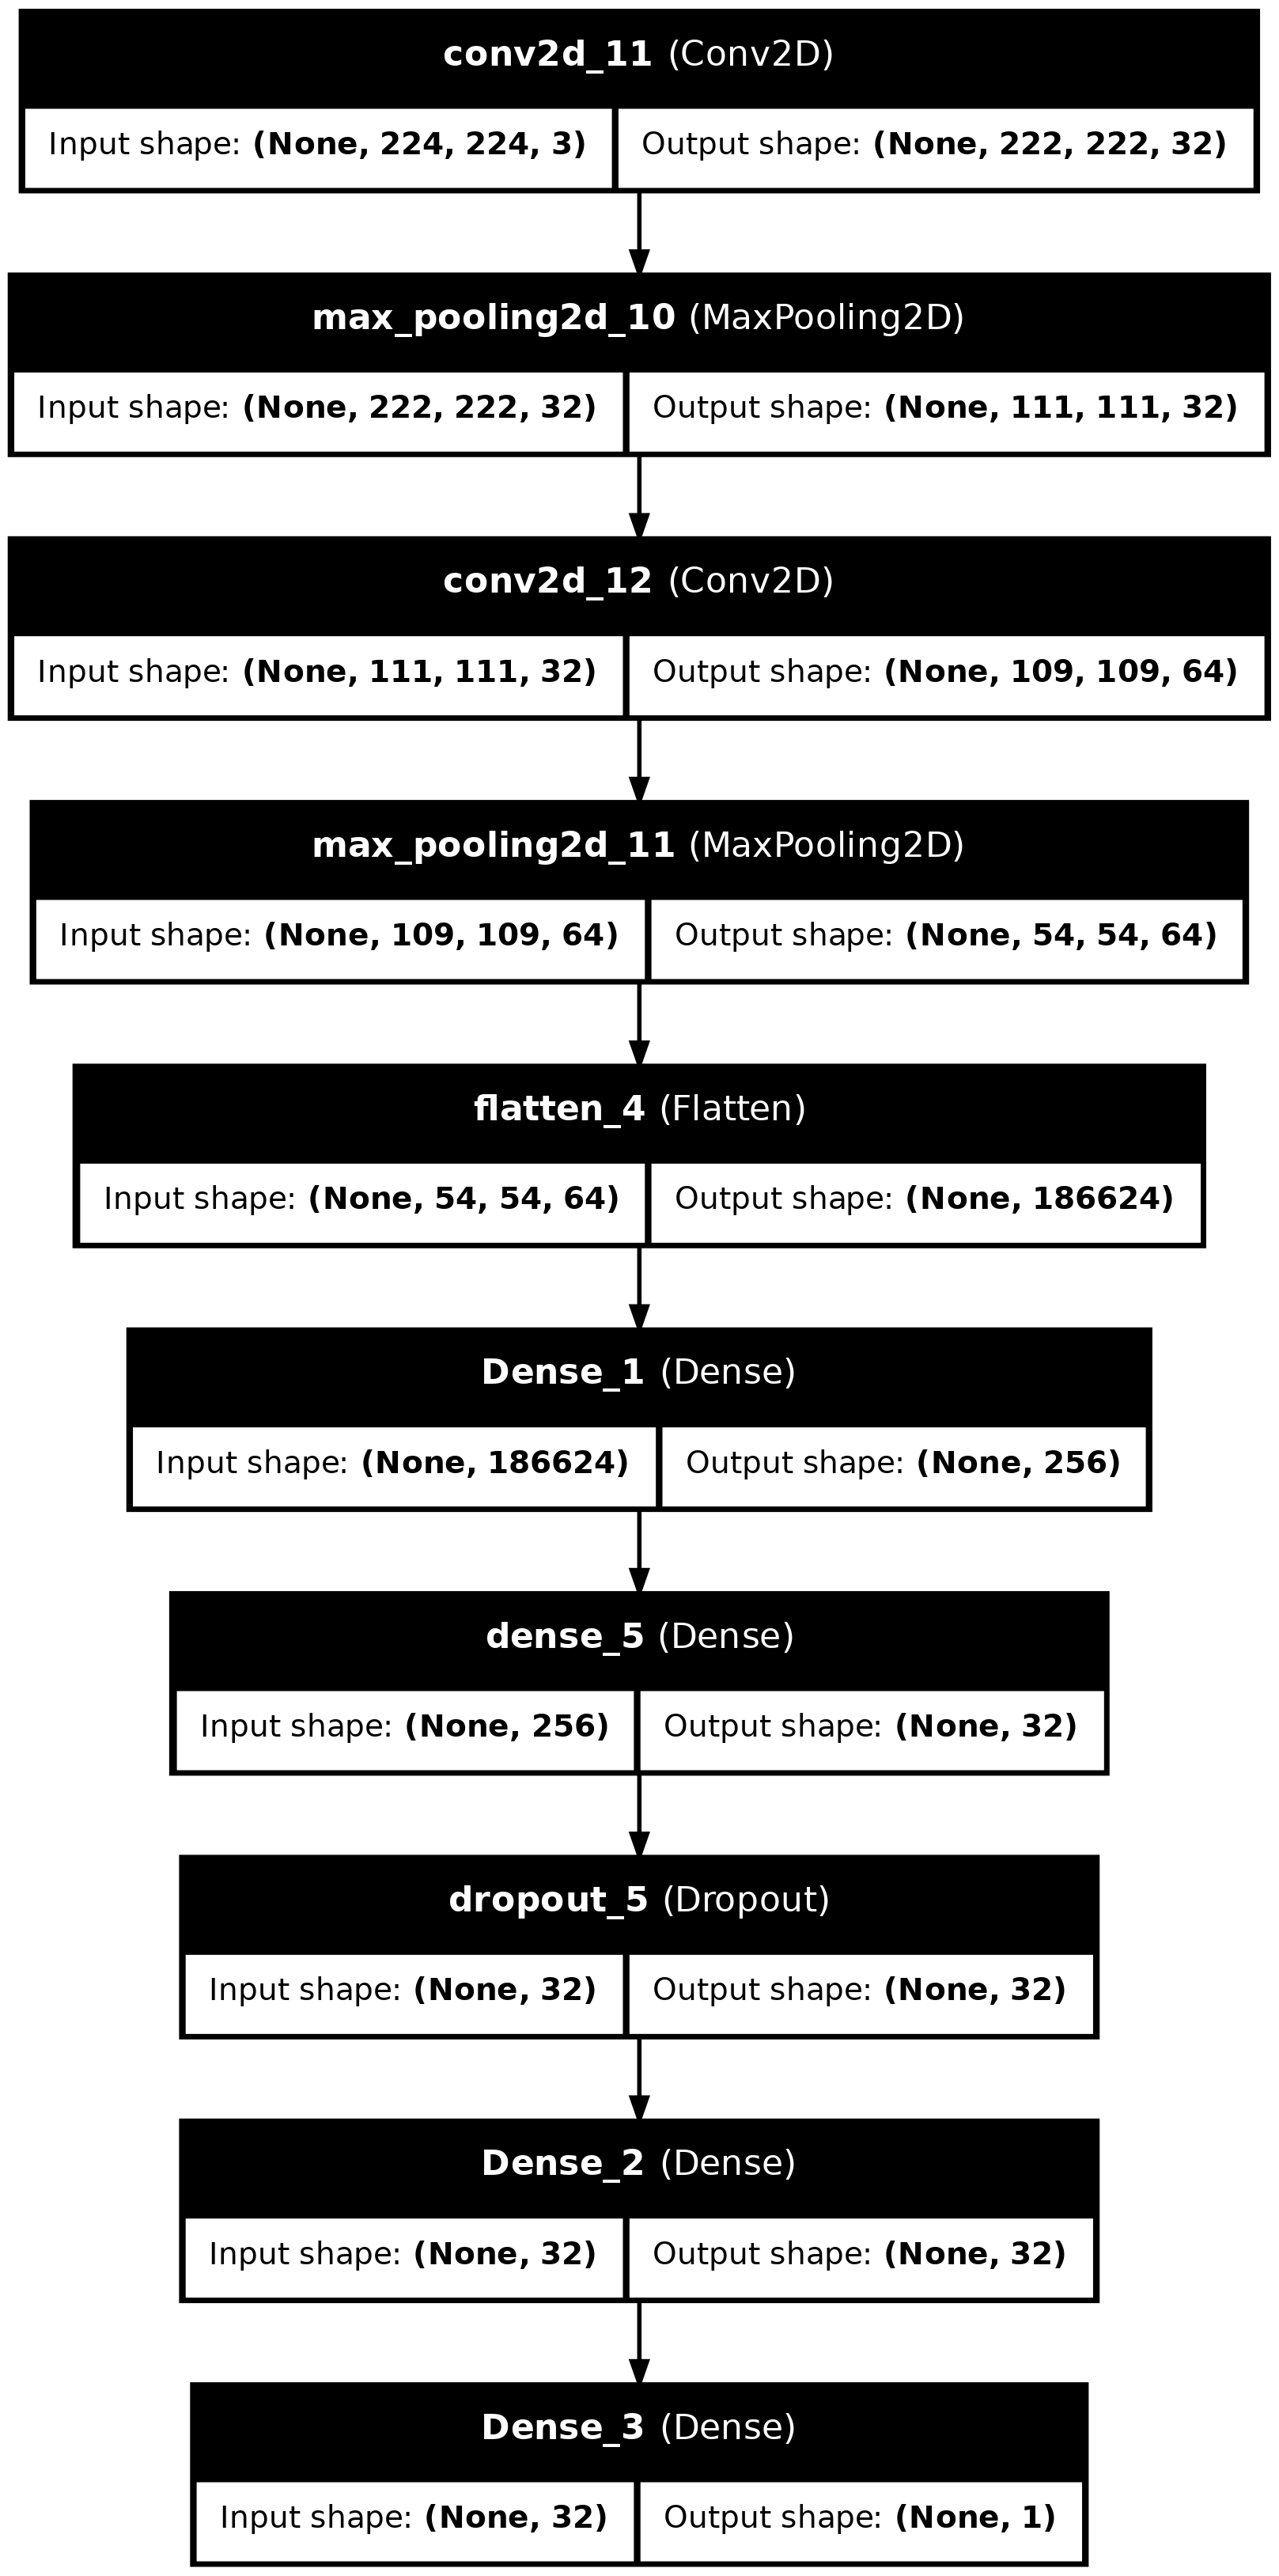

In [269]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Partie 6:

 - Entraînement du modèle


### Compiler votre modèle

In [270]:
# Compiler le model
model.compile(optimizer=optimizer,
    loss=loss,
    metrics=metrics)

#### Early stopping

In [271]:
early_stopping_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = callbacks.ModelCheckpoint("model.h5", save_best_only=True)

### Entraîner le modèle

In [272]:
# Fit the model 
history = model.fit(x=x_train, y=y_train, 
                              epochs=epochs, 
                              validation_data=(x_val, y_val),
                              callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5065 - loss: 1.2980

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.5052 - loss: 1.2853 - val_accuracy: 0.5000 - val_loss: 0.6977
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5175 - loss: 0.7017

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 252ms/step - accuracy: 0.5180 - loss: 0.7016 - val_accuracy: 0.5101 - val_loss: 0.6634
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6140 - loss: 0.6327

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - accuracy: 0.6133 - loss: 0.6334 - val_accuracy: 0.7374 - val_loss: 0.6216
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.6344 - loss: 0.6382 - val_accuracy: 0.5000 - val_loss: 0.8385
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - accuracy: 0.6136 - loss: 0.6348 - val_accuracy: 0.4949 - val_loss: 0.8209
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.4668 - loss: 0.7514

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.4712 - loss: 0.7483 - val_accuracy: 0.7475 - val_loss: 0.5636
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6743 - loss: 0.5807

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.6739 - loss: 0.5809 - val_accuracy: 0.7323 - val_loss: 0.5292
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.6904 - loss: 0.5675 - val_accuracy: 0.5152 - val_loss: 0.6901
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6808 - loss: 0.5738

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.6816 - loss: 0.5741 - val_accuracy: 0.8333 - val_loss: 0.4919
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7386 - loss: 0.5606

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - accuracy: 0.7392 - loss: 0.5598 - val_accuracy: 0.8485 - val_loss: 0.4559
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 255ms/step - accuracy: 0.7235 - loss: 0.5596 - val_accuracy: 0.8131 - val_loss: 0.4865
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.7192 - loss: 0.5680 - val_accuracy: 0.7576 - val_loss: 0.5216
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7041 - loss: 0.5557

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 272ms/step - accuracy: 0.7045 - loss: 0.5551 - val_accuracy: 0.8384 - val_loss: 0.4027
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.6628 - loss: 0.5937 - val_accuracy: 0.8283 - val_loss: 0.4224
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step - accuracy: 0.7467 - loss: 0.5165 - val_accuracy: 0.7475 - val_loss: 0.4992
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.7521 - loss: 0.4872 - val_accuracy: 0.6970 - val_loss: 0.5623
Epoch 17/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7711 - loss: 0.4979

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - accuracy: 0.7715 - loss: 0.4966 - val_accuracy: 0.8485 - val_loss: 0.3774
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.7969 - loss: 0.4482 - val_accuracy: 0.7727 - val_loss: 0.4189
Epoch 19/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.7726 - loss: 0.4611 - val_accuracy: 0.6313 - val_loss: 0.6190
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7151 - loss: 0.4965

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.7169 - loss: 0.4949 - val_accuracy: 0.8586 - val_loss: 0.3541


### Fonction coût pour l'ensemble d'entraînement et de validation

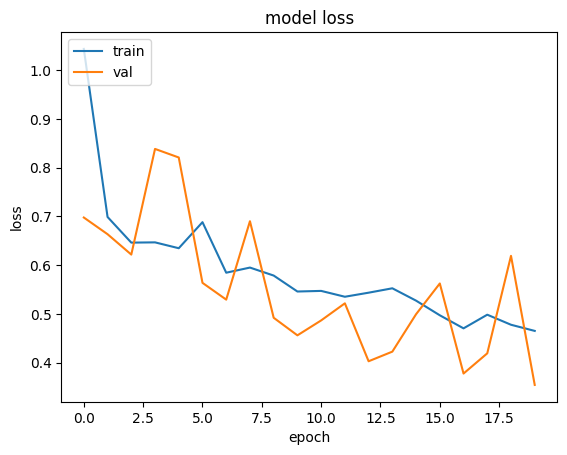

In [273]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Comparaison entre l'exactitude de l'ensemble d'entraînement et l'ensemble de validation

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
0.8585858345031738


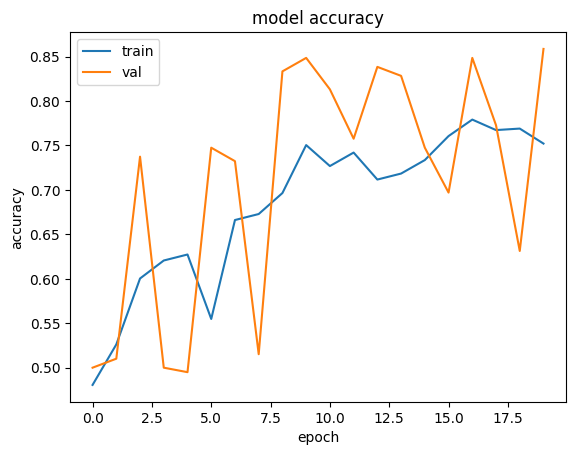

In [274]:

print(history.history.keys())
print(history.history['val_accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Partie 7:

 - Tester et valider le modèle

### Évaluation du model sur les jeux de données de l'ensenble de test

In [275]:
# Assuming you have a trained model
loss, accuracy = model.evaluate(x=x_val, y=y_val)
print(f"Val Loss: {loss}")
print(f"Val Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8299 - loss: 0.3819
Val Loss: 0.35410359501838684
Val Accuracy: 0.8585858345031738



## Partie 8:

   - Inférence



In [326]:
model = load_model('model.h5')

In [277]:
proportion = 0.01

In [278]:
datasets_ = CustomDataset(proportion=proportion, root = root, train=False, size=(224,224),shuffle=True, normalize=True)

In [279]:
images_ , target_ = datasets_.dataloader()

In [280]:
labelstate = ['benign', 'malignant']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


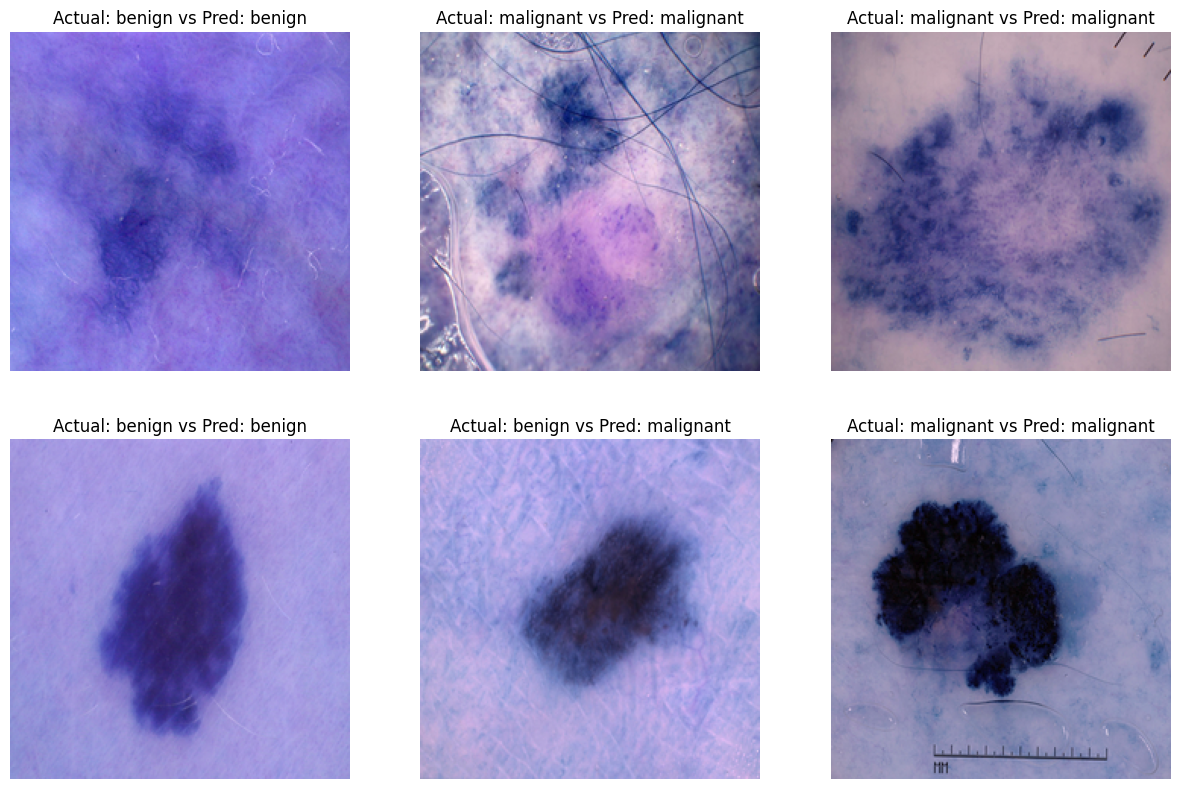

In [283]:
plt.figure(figsize=(15, 15))

i = 0

for  image, label in zip(images_[:9],target_[:9]):
    ax = plt.subplot(3, 3, i + 1)
    
    img = cv2.resize(image,(224,224))
    img = np.reshape(image,[1,224,224,3])

    pred = 0 if model.predict(img) <0.5 else 1
   
    plt.imshow(np.array(image*255).astype("uint8"))
    plt.title("Actual: "+label+" vs "+"Pred: "+labelstate[pred])
    plt.axis("off")
    i+=1

## Partie 9

 - Modèle préentraîné

In [331]:
base_model = applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step


In [332]:
# Create new model on top
inputs = Input(shape=(224, 224, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)  # Regularize with dropout
outputs = Dense(1)(x)
model = Model(inputs, outputs)

model.summary(show_trainable=True)


Model: "functional_98"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_7 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 7, 7, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_6 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_6 (Dense)             │ (None, 1)             │      2,049 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [340]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [341]:
early_stopping_cb = callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = callbacks.ModelCheckpoint("modelft.h5", save_best_only=True)

In [342]:
# Fit the model 
history = model.fit(x=x_train, y=y_train, 
                              epochs=epochs, 
                              validation_data=(x_val, y_val),
                              callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.5428 - loss: 1.8388

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 943ms/step - accuracy: 0.5425 - loss: 1.7987 - val_accuracy: 0.5000 - val_loss: 0.8063
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 977ms/step - accuracy: 0.5221 - loss: 0.7426 - val_accuracy: 0.5000 - val_loss: 0.8637
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.5614 - loss: 0.6990

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5609 - loss: 0.6989 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.5489 - loss: 0.7057

19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5494 - loss: 0.7059 - val_accuracy: 0.5051 - val_loss: 0.6869
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.5353 - loss: 0.6941

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5359 - loss: 0.6939 - val_accuracy: 0.6616 - val_loss: 0.6844
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5576 - loss: 0.6845 - val_accuracy: 0.5000 - val_loss: 0.6856
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 992ms/step - accuracy: 0.5125 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.7110
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5284 - loss: 0.7143 - val_accuracy: 0.5000 - val_loss: 0.7016
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5565 - loss: 0.7025 - val_accuracy: 0.5000 - val_loss: 0.6921
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.5588 - loss: 0.6980

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5567 - loss: 0.6986 - val_accuracy: 0.5000 - val_loss: 0.6839
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.5670 - loss: 0.6919

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5665 - loss: 0.6918 - val_accuracy: 0.6566 - val_loss: 0.6827
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 992ms/step - accuracy: 0.5460 - loss: 0.7006 - val_accuracy: 0.5000 - val_loss: 0.7480
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 995ms/step - accuracy: 0.5821 - loss: 0.6814 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 993ms/step - accuracy: 0.4922 - loss: 0.7069 - val_accuracy: 0.5000 - val_loss: 0.7574
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 996ms/step - accuracy: 0.5660 - loss: 0.6926 - val_accuracy: 0.5000 - val_loss: 0.7357
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 995ms/step - accuracy: 0.5639 - loss: 0.6756 - val_accuracy: 0.5000 - val_loss: 0.8527
Epoch 17/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.5249 - loss: 0.7170

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5256 - loss: 0.7162 - val_accuracy: 0.6515 - val_loss: 0.6800
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.5763 - loss: 0.6827

19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5756 - loss: 0.6827 - val_accuracy: 0.6111 - val_loss: 0.6799
Epoch 19/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 997ms/step - accuracy: 0.5405 - loss: 0.6857 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5743 - loss: 0.6768 - val_accuracy: 0.5000 - val_loss: 0.7194


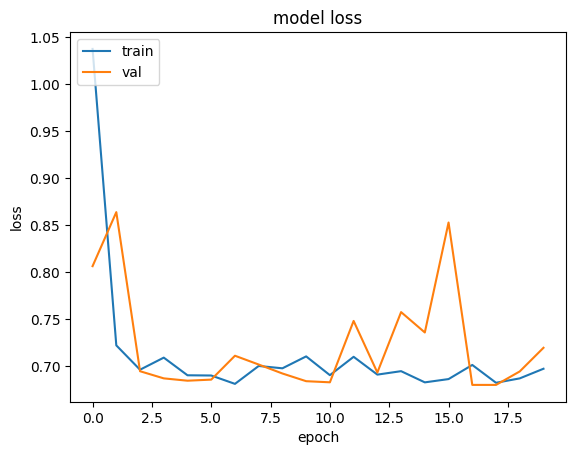

In [343]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
0.5


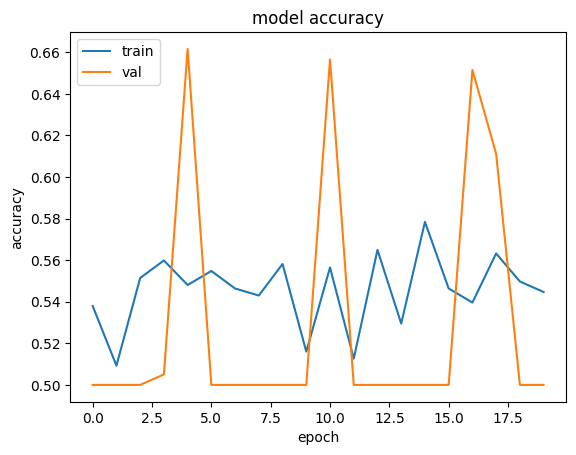

In [344]:

print(history.history.keys())
print(history.history['val_accuracy'][-1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [345]:
# Assuming you have a trained model
loss, accuracy = model.evaluate(x=x_val, y=y_val)
print(f"Val Loss: {loss}")
print(f"Val Accuracy: {accuracy}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 571ms/step - accuracy: 0.6519 - loss: 0.6765
Val Loss: 0.6799370646476746
Val Accuracy: 0.6111111044883728


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


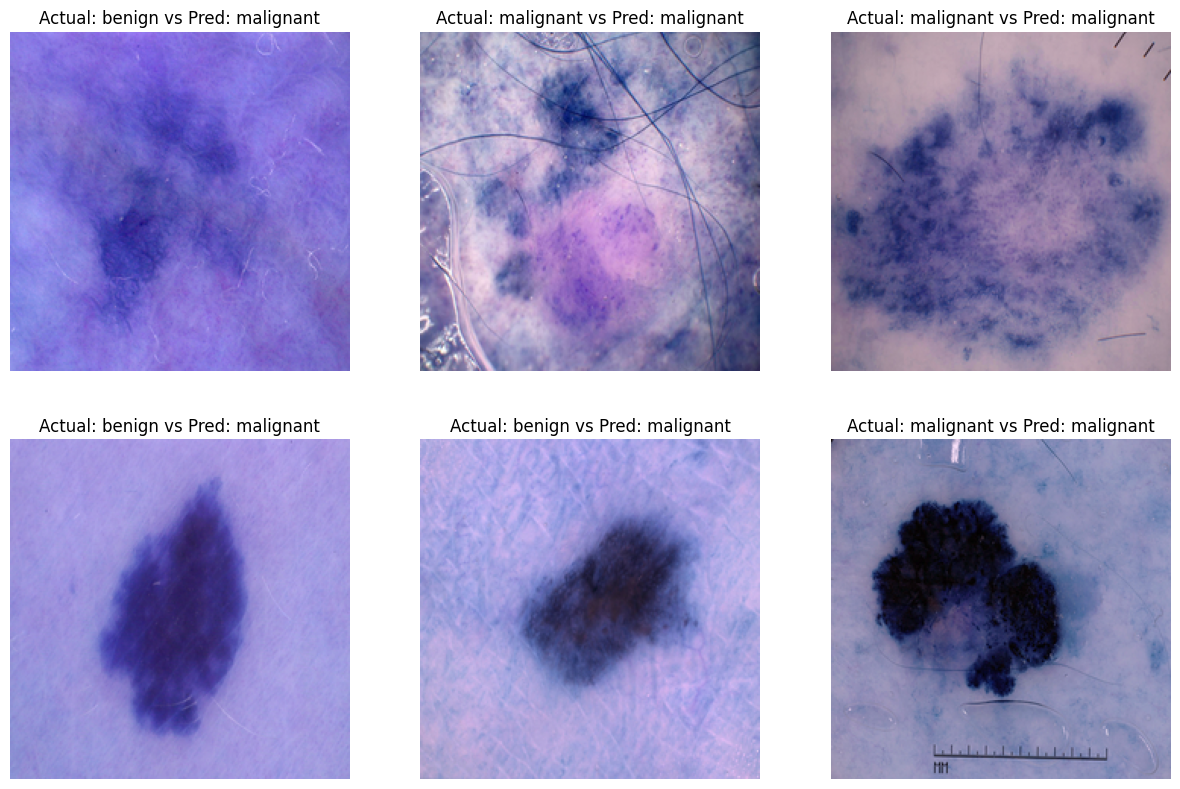

In [346]:
plt.figure(figsize=(15, 15))

i = 0

for  image, label in zip(images_[:9],target_[:9]):
    ax = plt.subplot(3, 3, i + 1)
    
    img = cv2.resize(image,(224,224))
    img = np.reshape(image,[1,224,224,3])

    pred = 0 if model.predict(img) <0.5 else 1
   
    plt.imshow(np.array(image*255).astype("uint8"))
    plt.title("Actual: "+label+" vs "+"Pred: "+labelstate[pred])
    plt.axis("off")
    i+=1